[[285.  45.]
 [ 45.   9.]]
[1.95365805 1.59878776]


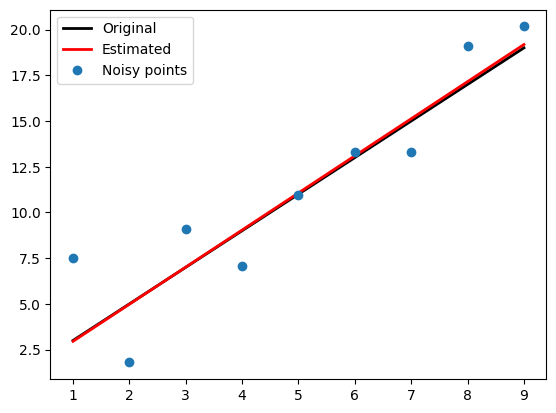

In [1]:
# Least-Squares
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

m = 2 # Line equation: y = m*x + c. m is the slope. c is the intercept.
c = 1
x = np.arange(1,10, 1)
n = 2.*np.random.randn(len(x)) # Noise
o = np.zeros(x.shape)
y = m*x + c + n + o # Noisy points confirming to a line

X = np.concatenate([x.reshape(len(x),1), np.ones((len(x), 1))], axis=1)
print(X.transpose()@X)
B = np.linalg.pinv(X.T@X)@X.T@y # Pseudo inverse computation
print(B)
mstar = B[0]
cstar = B[1]

plt.plot([x[0], x[-1]], [m*x[0] + c, m*x[-1]+c], color='k', linestyle='-', linewidth=2, label=r'Original')
plt.plot([x[0], x[-1]], [mstar*x[0] + c, mstar*x[-1]+cstar], 
         color='r', linestyle='-', linewidth=2, label=r'Estimated')
plt.plot(x,y, 'o', label='Noisy points')
plt.legend(loc='best')

[[1017.25  114.5 ]
 [ 114.5    19.  ]]
[ 2.85434743 -3.26175394]


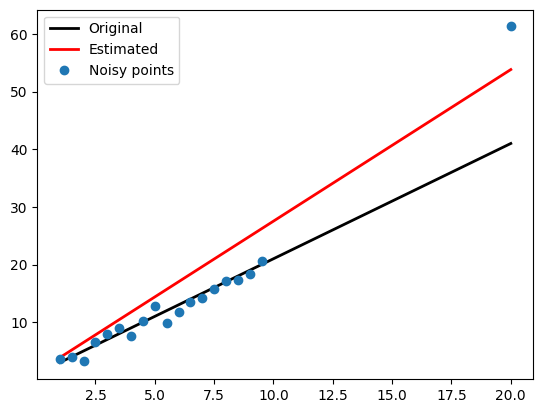

In [2]:
# Total Least Squares

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg

m = 2
c = 1
x = np.arange(1,10, 0.5) # Un-corrupted x
# Append a number to x
x = np.append(x, 20)
n = np.random.randn(len(x))
o = np.zeros(x.shape)
o[-1] = 20 # Outliers
y = m*x + c + n + o

X = np.concatenate([x.reshape(len(x),1), np.ones((len(x), 1))], axis=1)
print(X.transpose()@X)
B = np.linalg.pinv(X.T@X)@X.T@y
print(B)
mstar = B[0]
cstar = B[1]

plt.plot([x[0], x[-1]], [m*x[0] + c, m*x[-1]+c], color='k', linestyle='-', linewidth=2, label=r'Original')
plt.plot([x[0], x[-1]], [mstar*x[0] + c, mstar*x[-1]+cstar], 
         color='r', linestyle='-', linewidth=2, label=r'Estimated')
plt.plot(x,y, 'o', label='Noisy points')
plt.legend(loc='best')

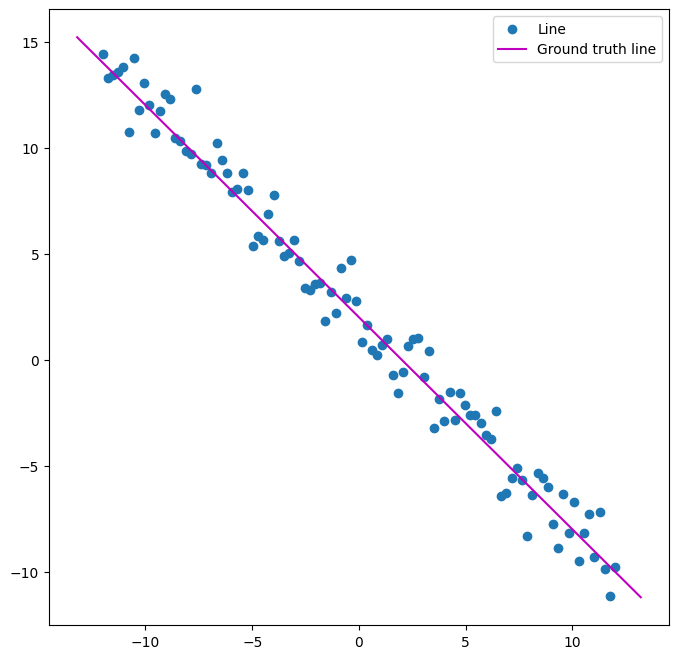

In [4]:
# Generation of a Noisy Point Set Conforming to a Line and a Circle
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib
# np.random.seed(0)
N = 100
t = np.random.uniform(0, 2*np.pi, N)

s = 1.
m, c = -1, 2
x = np.linspace(-12, 12, N) 
y = m*x + c + s*np.random.randn(N)
X_line = np.hstack((x.reshape(N,1), y.reshape(N,1))) 

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0],X_line[:,1], label='Line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m*x_ + c
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

Best line model [0.71330943 0.70084924 1.48294861]


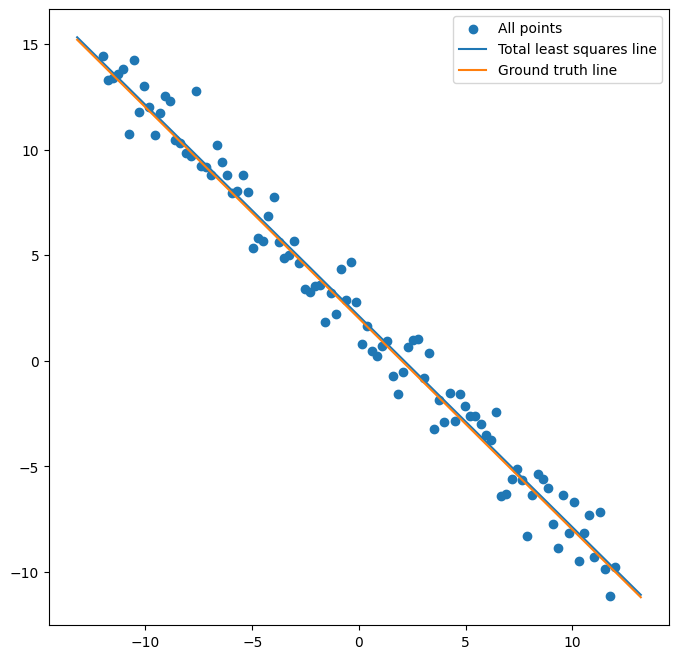

In [5]:
# Item 2: Line fitting with Total Least Squares
import math
N = X_line.shape[0]
X_ = X_line


U = X_ - np.mean(X_, axis=0)

# Eigenvector of 𝑈^𝑇𝑈 associated with the smallest eigenvalue
_, _, Vt = np.linalg.svd(np.transpose(U)@U)
a, b = Vt[-1, 0], Vt[-1, 1]
d = a*np.mean(X_[:,0]) + b*np.mean(X_[:,1])
best_model_line = np.array([a, b, d])

print('Best line model', best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0],X_line[:,1], label='All points')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_, label='Total least squares line')
y_ = m*x_ + c
plt.plot(x_, y_, label='Ground truth line')
plt.legend()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.946985407978339e-07
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10.067050909708703
            Iterations: 4
            Function evaluations: 22
            Gradient evaluations: 4
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.2762929660956672e-08
            Iterations: 6
            Function evaluations: 27
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.027292784026842e-10
            Iterations: 6
            Function evaluations: 29
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.712962663135308
            Iterations: 4
            Function eva

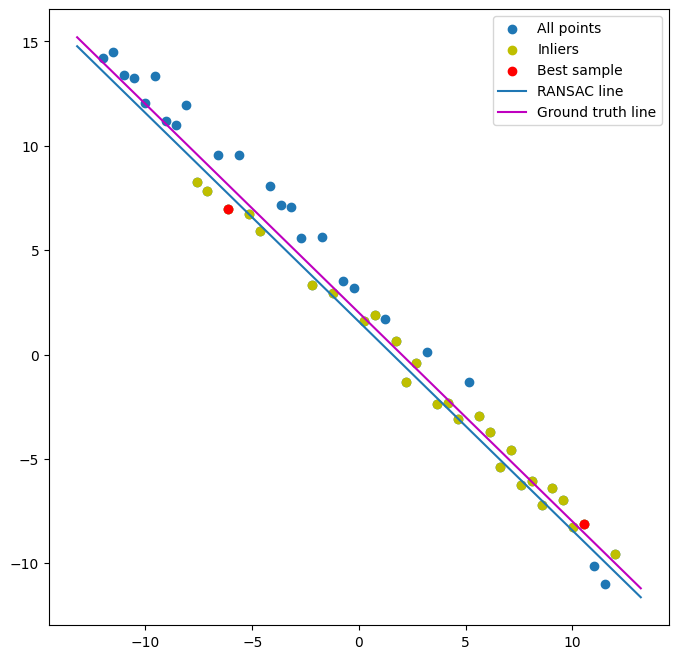

In [41]:
# Item 2: Total least squares line fitting with scicpy.optimize with RANSAC
import math
N = X_line.shape[0]
X_ = X_line

def line_equation_from_points(x1, y1, x2, y2):
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)

    # Return the line equation in the form ax + by = d
    return a, b, d

# RANSAC to fit a line
def line_tls(x, indices):
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*X_[indices,0] + b*X_[indices,1] - d))

# Constraint
def g(x):
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

# Computing the consensus (inliers)
def consensus_line(X, x, t):
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*X_[:,0] + b*X_[:,1] - d)
    return error < t

t = 1.   # Threshold value to determine data points that are fit well by model.
d = 0.4*N   # Number of close data points required to assert that a model fits well to data.
s = 2       # Minimum number of data points required to estimate model parameters.

inliers_line = []        # Indinces of the inliers
max_iterations = 50
iteration = 0
best_model_line = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_line = []    # Three-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, d) only using the best sample
best_inliers_line = []   # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(X_, res.x, t) # Computing the inliers
    #print('rex.x: ', res.x)    
    #print('Iteration = ', iteration, '. No. inliners = ', inliers_line.sum())
    if inliers_line.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
        #print(res.x, res.fun)
        if res.fun < best_error:
            #print('A better model found ... ', res.x, res.fun)
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = X_[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1

#print('Best line model', best_model_line)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(X_line[:,0],X_line[:,1], label='All points')
ax.scatter(X_[best_inliers_line,0],X_[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

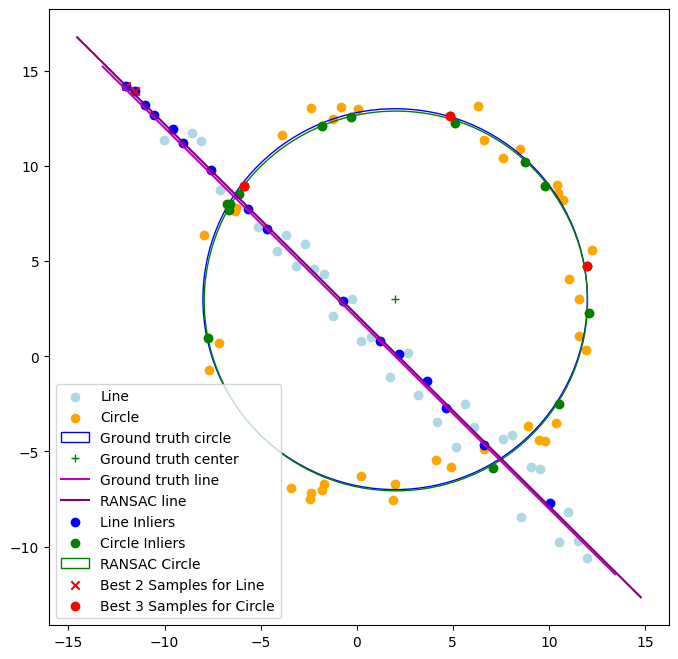

In [143]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt

# Seed for reproducibility
np.random.seed(1)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center of the circle
s = r / 16

# Generate points for the circle
theta = np.random.uniform(0, 2 * np.pi, half_n)
noise = s * np.random.randn(half_n)
x_circle = x0_gt + (r + noise) * np.cos(theta)
y_circle = y0_gt + (r + noise) * np.sin(theta)

X_circ = np.column_stack((x_circle, y_circle))

# Generate points for the line
s = 1.0
m, b = -1, 2

x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s * np.random.randn(half_n)

X_line = np.column_stack((x_line, y_line))

# Concatenate points from both circle and line to create X
X = np.vstack((X_circ, X_line))

# Plot the noisy points, ground truth line, and ground truth circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], color = 'lightblue', label='Line')
ax.scatter(X_circ[:, 0], X_circ[:, 1], color = 'orange', label='Circle')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='blue', fill=False, label='Ground truth circle')
ax.add_artist(circle_gt)
ax.plot(x0_gt, y0_gt, '+g', label='Ground truth center')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = m * x_range + b
plt.plot(x_range, y_range, color='m', label='Ground truth line')



# Define a function to calculate the line equation from two points
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

# RANSAC to fit a line with unit normal constraint
def ransac_line(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 2, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        
        a, b, d = line_equation_from_points(x1, y1, x2, y2)
        
        # Constraint: Ensure unit normal vector
        magnitude = np.sqrt(a**2 + b**2)
        a /= magnitude
        b /= magnitude
        
        # Calculate the distance of all points to the line
        distances = np.abs(a*X[:,0] + b*X[:,1] - d)
        
        # Find inliers based on the threshold
        inliers = np.where(distances < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (a, b, d)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters
iterations = 10000
threshold = 0.15
min_inliers = 15

# Estimate the line using RANSAC
best_line_model, Line_inlier_indices = ransac_line(X_line, iterations, threshold, min_inliers)

# Define a function to calculate the circle equation from three points
def circle_equation_from_points(x1, y1, x2, y2, x3, y3):
    # Calculate the midpoints of two line segments
    mx1, my1 = (x1 + x2) / 2, (y1 + y2) / 2
    mx2, my2 = (x2 + x3) / 2, (y2 + y3) / 2
    
    # Calculate the slopes of the two lines
    if y2 - y1 == 0:
        slope1 = 0  # Avoid division by zero
    else:
        slope1 = (x2 - x1) / (y2 - y1)
    
    if y3 - y2 == 0:
        slope2 = 0  # Avoid division by zero
    else:
        slope2 = (x3 - x2) / (y3 - y2)
    
    # Calculate the center of the circle
    x_center = (slope1 * mx1 - slope2 * mx2 + my2 - my1) / (slope1 - slope2)
    y_center = -slope1 * (x_center - mx1) + my1
    
    # Calculate the radius
    radius = np.sqrt((x1 - x_center)**2 + (y1 - y_center)**2)
    
    return x_center, y_center, radius

# RANSAC to fit a circle
def ransac_circle(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 3, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        x3, y3 = X[sample_indices[2]]
        
        x_center, y_center, radius = circle_equation_from_points(x1, y1, x2, y2, x3, y3)
        
        # Calculate the radial error of all points to the circle
        errors = np.abs(np.sqrt((X[:, 0] - x_center)**2 + (X[:, 1] - y_center)**2) - radius)
        
        # Find inliers based on the threshold
        inliers = np.where(errors < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (x_center, y_center, radius)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters for circle estimation
circle_iterations = 10000
circle_threshold = 0.2  # Adjust the threshold as needed
circle_min_inliers = 15

# Identify the remnant points (not explained by the line)
remnant_indices = [i for i in range(len(X)) if i not in Line_inlier_indices]
remnant_points = X[remnant_indices]

# Estimate the circle using RANSAC
best_circle_model, circle_inlier_indices = ransac_circle(remnant_points, circle_iterations, circle_threshold, circle_min_inliers)


# Plot the results

# Plot the estimated line
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_model[0] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='RANSAC line', color='purple')


ax.scatter(X_line[Line_inlier_indices, 0], X_line[Line_inlier_indices, 1], color='blue', label='Line Inliers')


# Find the best 2 samples for the line
best_line_sample_indices = Line_inlier_indices[:2]
best_line_samples = X_line[best_line_sample_indices]


# Plot the inliers of the circle
ax.scatter(remnant_points[circle_inlier_indices, 0], remnant_points[circle_inlier_indices, 1], color='g', label='Circle Inliers')

# Plot the estimated circle
x_center, y_center, radius = best_circle_model
circle_estimated = plt.Circle((x_center, y_center), radius, color='g', fill=False, label='RANSAC Circle')
ax.add_artist(circle_estimated)

# Find the best 3 samples for the circle (using circle_inlier_indices)
best_circle_sample_indices = circle_inlier_indices[:3]
best_circle_samples = remnant_points[best_circle_sample_indices]


# Plot the best 2 samples for the line and the best 3 samples for the circle
ax.scatter(best_line_samples[:, 0], best_line_samples[:, 1], color='red', marker='x', label='Best 2 Samples for Line')
ax.scatter(best_circle_samples[:, 0], best_circle_samples[:, 1], color='red', marker='o', label='Best 3 Samples for Circle')


plt.legend()
plt.show()



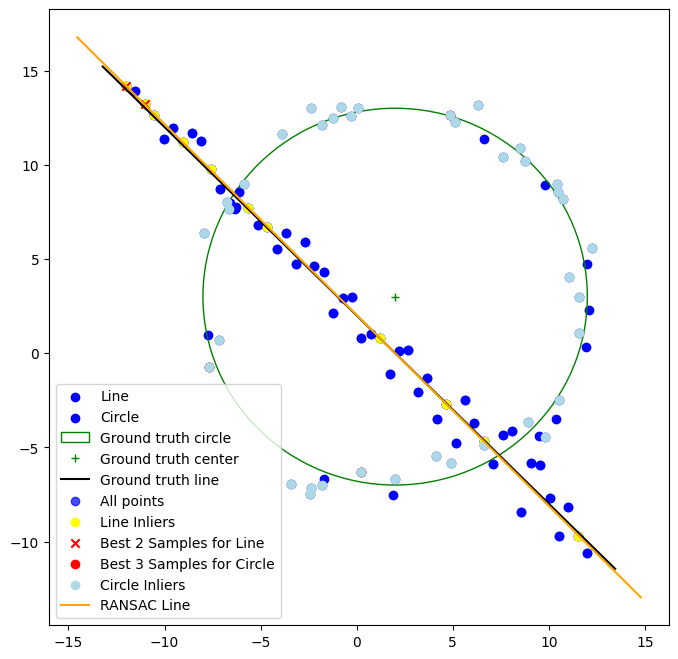

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Seed for reproducibility
np.random.seed(1)

N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center of the circle
s = r / 16

# Generate points for the circle
theta = np.random.uniform(0, 2 * np.pi, half_n)
noise = s * np.random.randn(half_n)
x_circle = x0_gt + (r + noise) * np.cos(theta)
y_circle = y0_gt + (r + noise) * np.sin(theta)

X_circ = np.column_stack((x_circle, y_circle))

# Generate points for the line
s = 1.0
m, b = -1, 2

x_line = np.linspace(-12, 12, half_n)
y_line = m * x_line + b + s * np.random.randn(half_n)

X_line = np.column_stack((x_line, y_line))

# Concatenate points from both circle and line to create X
X = np.vstack((X_circ, X_line))

# Plot the noisy points, ground truth line, and ground truth circle
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line', color='blue')
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle', color='blue')
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='green', fill=False, label='Ground truth circle')
ax.add_artist(circle_gt)
ax.plot(x0_gt, y0_gt, '+g', label='Ground truth center')
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = m * x_range + b
plt.plot(x_range, y_range, color='black', label='Ground truth line')

# Define a function to calculate the line equation from two points
def line_equation_from_points(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude
    d = (a * x1) + (b * y1)
    return a, b, d

# RANSAC to fit a line with unit normal constraint
def ransac_line(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 2, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        
        a, b, d = line_equation_from_points(x1, y1, x2, y2)
        
        # Constraint: Ensure unit normal vector
        magnitude = np.sqrt(a**2 + b**2)
        a /= magnitude
        b /= magnitude
        
        # Calculate the distance of all points to the line
        distances = np.abs(a*X[:,0] + b*X[:,1] - d)
        
        # Find inliers based on the threshold
        inliers = np.where(distances < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (a, b, d)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters
iterations = 10000
threshold = 0.05
min_inliers = 10

# Estimate the line using RANSAC
best_line_model, Line_inlier_indices = ransac_line(X_line, iterations, threshold, min_inliers)

# RANSAC to fit a circle
def ransac_circle(X, iterations, threshold, min_inliers):
    best_model = None
    best_inliers = []
    
    for _ in range(iterations):
        sample_indices = np.random.choice(len(X), 3, replace=False)
        x1, y1 = X[sample_indices[0]]
        x2, y2 = X[sample_indices[1]]
        x3, y3 = X[sample_indices[2]]
        
        x_center, y_center, radius = circle_equation_from_points(x1, y1, x2, y2, x3, y3)
        
        # Calculate the radial error of all points to the circle
        errors = np.abs(np.sqrt((X[:, 0] - x_center)**2 + (X[:, 1] - y_center)**2) - radius)
        
        # Find inliers based on the threshold
        inliers = np.where(errors < threshold)[0]
        
        if len(inliers) >= min_inliers:
            if len(inliers) > len(best_inliers):
                best_model = (x_center, y_center, radius)
                best_inliers = inliers
                
    return best_model, best_inliers

# RANSAC parameters for circle estimation
circle_iterations = 10000
circle_threshold = 0.1
circle_min_inliers = 10

# Estimate the circle using RANSAC
best_circle_model, Circle_inlier_indices = ransac_circle(X_circ, circle_iterations, circle_threshold, circle_min_inliers)

# Identify the remnant points (not explained by the line)
remnant_indices = [i for i in range(len(X_circ)) if i not in Circle_inlier_indices]
remnant_points = X_circ[remnant_indices]

# Find the best 2 samples for the line
best_line_sample_indices = Line_inlier_indices[:2]
best_line_samples = X_line[best_line_sample_indices]

# Find the best 3 samples for the circle (using Circle_inlier_indices)
best_circle_sample_indices = Circle_inlier_indices[:3]
best_circle_samples = remnant_points[best_circle_sample_indices]

# Plot the results

ax.scatter(X_line[:, 0], X_line[:, 1], color='blue', alpha=0.7, label='All points')
ax.scatter(X_line[Line_inlier_indices, 0], X_line[Line_inlier_indices, 1], color='yellow', label='Line Inliers')

# Plot the best 2 samples for the line 
ax.scatter(best_line_samples[:, 0], best_line_samples[:, 1], color='red', marker='x', label='Best 2 Samples for Line')

# the best 3 samples for the circle
ax.scatter(best_circle_samples[:, 0], best_circle_samples[:, 1], color='red', marker='o', label='Best 3 Samples for Circle')

# Plot the inliers of the circle
ax.scatter(remnant_points[:, 0], remnant_points[:, 1], color='lightblue', label='Circle Inliers')

# Plot the estimated circle
x_center, y_center, radius = best_circle_model
circle_estimated = plt.Circle((x_center, y_center), radius, color='purple', label='RANSAC Circle')

# Plot the estimated line
x_min, x_max = ax.get_xlim()
x_range = np.array([x_min, x_max])
y_range = (-best_line_model[0] * x_range + best_line_model[2]) / best_line_model[1]
plt.plot(x_range, y_range, label='RANSAC Line', color='orange')

plt.legend()
plt.show()
